In [1]:
import scipy.io
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline
import imageio
import numpy as np
%tensorflow_version 1.x
import tensorflow as tf

from utils import *
from costs import *

TensorFlow 1.x selected.


In [2]:
!wget https://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat 

--2021-06-28 09:44:25--  https://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat
Resolving www.vlfeat.org (www.vlfeat.org)... 64.90.48.57
Connecting to www.vlfeat.org (www.vlfeat.org)|64.90.48.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 534904783 (510M)
Saving to: ‘imagenet-vgg-verydeep-19.mat’

imagenet-vgg-veryde 100%[===================>] 510.12M  34.9MB/s    in 15s     

2021-06-28 09:44:41 (33.3 MB/s) - ‘imagenet-vgg-verydeep-19.mat’ saved [534904783/534904783]



In [2]:
# The layers which will be used for style and content cost computation respectively
STYLE_LAYERS = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
CONTENT_LAYER = 'conv4_2'

In [3]:
tf.compat.v1.reset_default_graph()
sess = tf.compat.v1.InteractiveSession()

content_image = loadimg("/content/louvre_small.jpg")
style_image = loadimg("/content/monet.jpg")
generated_image = generate_noise_image(content_image)

model = load_vgg_model("/content/imagenet-vgg-verydeep-19.mat")

sess.run(model["input"].assign(content_image))
out = model[CONTENT_LAYER]
a_C = sess.run(out)
a_G = out
J_content = compute_content_cost(a_C, a_G)

sess.run(model['input'].assign(style_image))
J_style = 0

for layer_name in STYLE_LAYERS:
        out = model[layer_name]
        a_S = sess.run(out)
        a_G = out
        J_style_layer = compute_style_cost(a_S, a_G)
        J_style += J_style_layer

J_style = J_style / len(STYLE_LAYERS)
J = total_cost(J_content, J_style, alpha = 10, beta = 40)

optimizer = tf.train.AdamOptimizer(2.0)
train_step = optimizer.minimize(J)

In [4]:
def model_nn(sess, input_image, num_iterations = 200, display_steps = 20, return_history = False):
    
    sess.run(tf.global_variables_initializer())
    sess.run(model['input'].assign(input_image))

    history = {"content_cost" : [],
               "style_cost" : [],
               "total_cost" : []}
    print("{:<15} {:<20} {:<20} {:<20}".format("Iteration", "Content Cost", "Style Cost", "Total Cost"))

    for i in range(num_iterations):
        somthing = sess.run(train_step)
        generated_image = sess.run(model['input'])
        Jt, Jc, Js = sess.run([J, J_content, J_style])
        history["content_cost"].append(Jc)
        history["style_cost"].append(Js)
        history["total_cost"].append(Jt)
        if i%display_steps == 0:
            print("{:<15} {:<20} {:<20} {:<20}".format(i, Jc, Js, Jt))
            '''print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            '''
    print("{:<15} {:<20} {:<20} {:<20}".format(num_iterations, Jc, Js, Jt))            
    if  return_history:
      return generated_image, history
    else:
      return generated_image

In [5]:
result = model_nn(sess, generated_image, num_iterations = 200, display_steps = 20)

Iteration       Content Cost         Style Cost           Total Cost          
0               7912.9716796875      126636208.0          5065527808.0        
20              15305.6064453125     23756922.0           950429952.0         
40              16925.673828125      12247763.0           490079776.0         
60              17585.44140625       7990019.0            319776608.0         
80              17915.8671875        5846537.0            234040624.0         
100             18126.3203125        4615303.0            184793392.0         
120             18303.263671875      3819798.0            152974960.0         
140             18439.080078125      3251931.25           130261640.0         
160             18541.2578125        2818567.5            112928120.0         
180             18629.978515625      2470748.0            99016216.0          
200             18720.49609375       2207361.75           88481680.0          


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


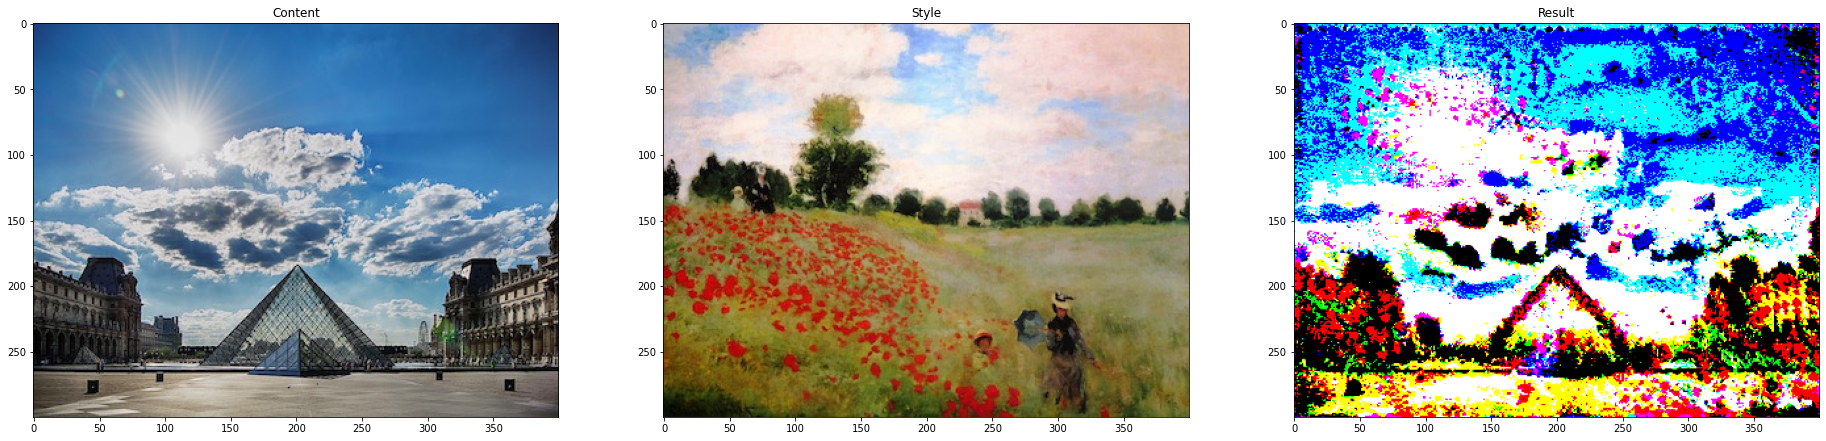

In [7]:
plt.subplots(1,3, figsize = (32,10))
plt.subplot(1,3,1)
imshow(imageio.imread('/content/louvre_small.jpg'))
plt.title("Content")
plt.subplot(1,3,2)
imshow(imageio.imread('/content/monet.jpg'))
plt.title("Style")
plt.subplot(1,3,3)
imshow(result[0])
plt.title("Result")
plt.show()